In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import warnings, scipy.sparse as sp, matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc_context
from collections import Counter
import matplotlib.font_manager
import matplotlib.lines as lines
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import muon as mu
#import pyreadr
#import rpy2
#from rpy2.robjects.packages import importr
#import rpy2.robjects as robjects
#import magic
import seaborn as sns
#import palantir
#import loompy
#from scipy.sparse import csgraph

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rc('font', size=14)

pd.set_option('display.max_rows', 200)

sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

/opt/anaconda3/envs/R-lisi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [2]:
import sknetwork as skn
from sknetwork.data import karate_club
from sknetwork.clustering import Louvain

In [3]:
# preset color palettes and color maps
user_defined_palette =  [ '#F6222E', '#16FF32', '#3283FE', '#FEAF16', '#BDCDFF', '#3B00FB', '#1CFFCE', '#C075A6', '#F8A19F', '#B5EFB5', '#FBE426', '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F', '#1C8356', '#0e452b', '#AA0DFE', '#B5EFB5', '#325A9B', '#90AD1C']

user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])

In [4]:
pip install igraph

Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib inline 

In [6]:
from muon import prot as pt

# Download muon file: "JEM2023.h5mu" from zenodo

In [7]:
import mudata as md

In [8]:
rna = md.read("JEM2023.h5mu/rna")

In [9]:
prot = md.read("JEM2023.h5mu/prot")
prot

AnnData object with n_obs × n_vars = 11287 × 67
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
rna

AnnData object with n_obs × n_vars = 11287 × 16153
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'LSK_clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'LSK_clusters_colors', 'hvg', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_0.7', 'leiden_0.7_colors', 'leiden_0.8', 'leiden_0.8_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'rna:LSK_clusters_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts', 'norm_log'
    obsp: 'connectivities', 'distances'

## HSC subsetting 

In [11]:
id_HSC = np.where(np.isin(rna.obs['LSK_clusters'], ['c1', 'c3','c7']))[0]

In [12]:
HSC = sc.AnnData(X= rna.X[id_HSC, :], 
                         obs = rna.obs.iloc[id_HSC, :], 
                        var = rna.var)
HSC.obsm['X_pca'] = rna.obsm['X_pca'][id_HSC, :]
HSC.obsm['X_umap'] = rna.obsm['X_umap'][id_HSC, :]

In [13]:
HSC

AnnData object with n_obs × n_vars = 2782 × 16153
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'LSK_clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [14]:
#cols_to_remove = ['leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8']  # Replace with actual column names
#HSC.obs.drop(columns=[col for col in cols_to_remove if col in HSC.obs.columns], inplace=True)

In [14]:
# Remove any unused categories
HSC.obs['LSK_clusters'] = HSC.obs['LSK_clusters'].cat.remove_unused_categories()

In [15]:
HSC.obs['LSK_clusters']

AAACCCAAGGAAAGAC-1    c1
AAACCCACAGTCACGC-1    c7
AAACCCATCAAGTGTC-1    c1
AAACCCATCAGACCGC-1    c1
AAACCCATCCAGTACA-1    c7
                      ..
TTTGATCGTCGTTTCC-1    c3
TTTGGAGAGAGCAGAA-1    c1
TTTGGTTAGGGAACAA-1    c3
TTTGTTGCACTTGAAC-1    c7
TTTGTTGTCTCATTGT-1    c1
Name: LSK_clusters, Length: 2782, dtype: category
Categories (3, object): ['c1', 'c3', 'c7']

In [16]:
prot.obs['LSK_clusters'] = rna.obs['LSK_clusters']

In [17]:
prot_id_HSC = np.where(np.isin(prot.obs['LSK_clusters'], ['c1', 'c3','c7']))[0]

In [18]:
HSCprot = sc.AnnData(X= prot.X[prot_id_HSC, :], 
                         obs = prot.obs.iloc[prot_id_HSC, :], 
                        var = prot.var)
HSCprot.obsm['X_pca'] = prot.obsm['X_pca'][prot_id_HSC, :]
HSCprot.obsm['X_umap'] = prot.obsm['X_umap'][prot_id_HSC, :]

In [19]:
# Remove any unused categories
HSCprot.obs['LSK_clusters'] = HSCprot.obs['LSK_clusters'].cat.remove_unused_categories()

In [20]:
HSCprot.obs['LSK_clusters']

AAACCCAAGGAAAGAC-1    c1
AAACCCACAGTCACGC-1    c7
AAACCCATCAAGTGTC-1    c1
AAACCCATCAGACCGC-1    c1
AAACCCATCCAGTACA-1    c7
                      ..
TTTGATCGTCGTTTCC-1    c3
TTTGGAGAGAGCAGAA-1    c1
TTTGGTTAGGGAACAA-1    c3
TTTGTTGCACTTGAAC-1    c7
TTTGTTGTCTCATTGT-1    c1
Name: LSK_clusters, Length: 2782, dtype: category
Categories (3, object): ['c1', 'c3', 'c7']

## Figure S2F

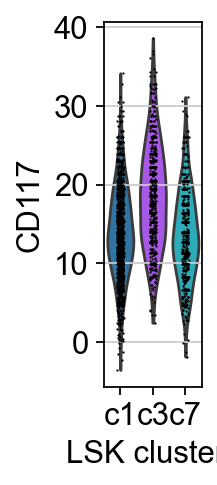

In [84]:
ax = sc.pl.violin(prot, 'CD117', 
                  groupby='LSK_clusters',   order=['c1', 'c3' ,'c7'],  
                  show=False  # Do not display the plot immediately
                 )

# Remove the legend
ax.legend_.remove()

# Save the figure as a PDF
#plt.savefig("Grimes_HSC_CD117.pdf", format="pdf")

# Now display the plot
plt.show()

In [22]:
rng = np.random.RandomState(42)
sc.tl.pca(HSC, svd_solver='arpack', random_state=rng)

computing PCA
    with n_comps=50
    finished (0:00:00)


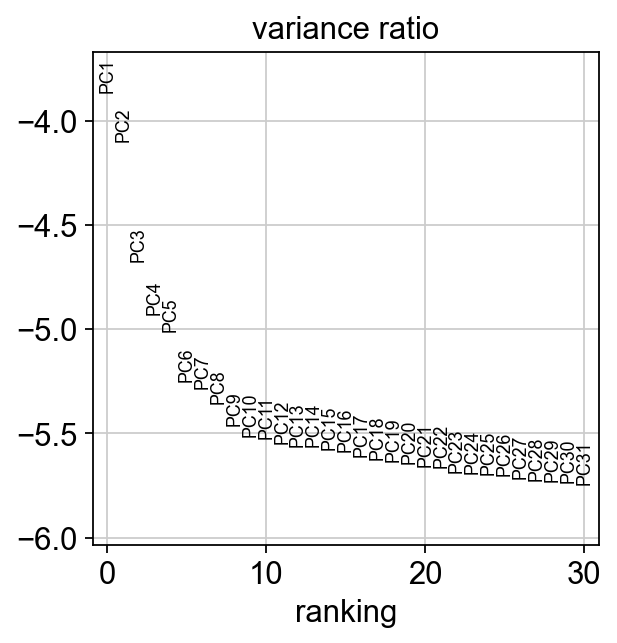

In [23]:
sc.pl.pca_variance_ratio(HSC, log=True)

In [24]:
import leidenalg

In [25]:
sc.pp.neighbors(HSC, n_neighbors=10, n_pcs=12)

computing neighbors
    using 'X_pca' with n_pcs = 12


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [26]:
for resolution_parameter in [0.5, 0.6, 0.7, 0.8]:
    sc.tl.leiden(HSC, resolution=resolution_parameter, random_state=42, 
                        key_added='leiden_'+str(resolution_parameter))

running Leiden clustering


/var/folders/rj/b218xr0s4qvdw1k7xjkdq21125c853/T/ipykernel_10440/2960030358.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(HSC, resolution=resolution_parameter, random_state=42,


    finished: found 9 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:00)


In [28]:
str6='Igf1	Inhba	Pdgfc	Cyp26b1	Rian	Ndnf	Dnm3	Chil5	Meis2	Shisa9	Meg3	9530026P05Rik	Gbp4	Gbp9	Chrm3	Bank1	Ahnak	Ncam2	Gbp6	Neo1	Glis3	Igf2bp2	Agbl1	Hoxb6	Gm28905	4933406I18Rik	Hid1	Gbp8	Pkhd1l1	Sult1a1	F830016B08Rik	Gm4951	Nav3	Nrg4	Setbp1	Mmp28	Plekhg1	Myof	Ppargc1a	Runx1t1	Iigp1	Pgr	Sox5	Rarb	Abcb1a	Clec1a	Ppp2r2b	Ksr2	Procr	Ifitm7	Cd74	Sbf2	Mmp16	Il1rapl2	Gm46210	Gm46515	Ifi44	Hif3a	Ptprk	Sgsm1	Dennd2a	Ltb	Rin2	Jam2	Cpeb3	Gm12185	Triqk	Ablim1	Magi2	Gimap5	Ly6a	Nr3c2	Prex2	Mettl7a1	Gm973	Plcl1	Gimap8	Tecpr1	Slc16a9	Abcg3	Cpne8	Gm4070	Klhl4	St8sia4	Fgd5	Gvin1	Pde2a	Rhoj	Entpd1	Acer2	Pclo	Pdgfd	Lancl3	Slfn5	Mamdc2	Ptpn14	Gbp5	Ms4a6b	Mettl27	Ldb2	Cd247	Map3k8	Tnip3	Gm17473	Arid5b	A330023F24Rik	Oasl2	Hoxa3	Lbp	Emcn	Arntl	Cnrip1	E230032D23Rik	Mirt1	Spaca6	Nsun7	Sorbs2	Notch1	Mill2	Unc13b	Airn	Evi5	Lhcgr	N4bp2l1	Rgl1	Il2rg	Npas3	Hivep3	Klhl3	Gm20559	2310001H17Rik	Fam135a	Trim34a	Tox	Zfp831	Sytl5	Bend7	Hoxb3	Gm17276	Pou2f2	Shisa5	Alcam	Anxa6	Fam169b	Zfp467	Hacd4	Nrk	0610043K17Rik	Neurl3	Tmem71	Tcp11l2	Camk2d	Gm16070	Palld	Dennd1c	Cyp2j6	Zc3h6	Thsd4'
q_HSC= str6.split('	')

In [29]:
str7= 'Fosb	Fos	Nfkbiz	Sik1	Cytip	Gm19590	Coq10b	Rgs1	Stk17b	Rel	Creb5	Junb	Myl10	Zfp831	Clnk	Dok6	Skil	Tiparp	Sox6	Rgs2	Gm29946	Csf3r	Flt3	Gm26802	Gm26887	C030034L19Rik	Fgfr1	Rnf150	Il18rap	Phldb2	Zc3h12a	Rmnd5b	Plaur	Paqr8	Bcl6	Dhrs11	Slc28a2	Nr4a1	Taf13	Tgif1	Kcnk12	Dusp6	Gm10563	Mirt1	Arid5b	Dusp1	Esr1	Klf4	Egr1	Zfp36	Klf6	Wdfy2	Klf2	Hist1h2ac	Ctsl	Hist1h2bc	Sqstm1	Paqr5'
MgK_HSC= str7.split('	')

In [30]:
str8= 'Itga2b	Plek	Slc22a3	Adgrl1	Tgfb1	Nucks1	H2afz	Fyb	Runx3	Ybx3	Stmn1	Baz1a	Nol4l	Hdgf	Rab27b	Hmgb2	Mki67	Pf4	Cavin2	Hspd1	Ipo5	AI504432	Ldha	Hnrnpab	Oxct1	Vcl	Ranbp1	Zfpm1	Ipo7	Pcna	Pa2g4	Nrgn	Pde5a	Slc16a10	Slc24a3	Vwf	Ran	Arhgap10	Nop56	Alyref	Knl1	E2f8	Slc9a9	Mvb12b	Dgkd	Slc25a5	Bmp2k	Etfb	Slc14a1	11-Sep	Anp32e	Nolc1	Rpn1	Dkc1	Actn4	Ak2	Naa50	F2r	Sntb1	Spidr	Mfsd2b	Hspe1	Plcb1	Nomo1	Paics	Ppat	Kalrn	Sla	Asap2	Dtymk	C1galt1	Hist1h2ap	Tanc1	AI506816	Foxk2	Cpsf2	Mid1	Ppfia1	Rangap1	Pdss1	Nme1	Eif3b	Hmgb3	Nup205	Cox5a	Snrpd1	Mob1b	Lrrc8b	Ssrp1	Hpf1	Haus6	Pde10a	Cox6a1	Agpat5	Khsrp	Nup155	Ppp1r14b	Mthfd1	Cep295	Myom1	Ywhah	Ptpn7	C1qbp	Sema4d	Nav1	Hmgn2	Lin54	P3h2	Hmgn5	Cct7	Hsph1	Nudc	Cdyl	Fbl	Slc20a1	Cacybp	Stip1	Pdap1	Ncoa3	Dpy19l1	Me2	Ppm1g	Rfwd3	Crip1	Orc2	Anln	Ubtf	Abracl	Snhg4	Inpp5a	Pdia6	Kif11	Parp1	Uba2	Vdac1	Ptger3	Raly	Depdc1b	Dnajc2	Ckap2l	Dnajc6	Srm	Nup107	Banf1	Bora	Siva1	Nckap1	Noc2l	Nup50	Atp1b3	Cd9	Hist1h1b	Sacs	Unc119	Lrp8	Hist1h2ae	Cox5b	Tex9	Ubxn2a	Sumo3	Snrpd3	Nhp2	Dot1l	Kmt5a	Eftud2	Ppp1ca	Foxn2	Mre11a	Heatr1	Etaa1	Pfas	Cdk4	Tada2a	Incenp	Atp5g1	Fkbp4	Tmem14c	Ddx1	Dynll1	Arl6ip6	Tpi1	Mdm1	Gart	Rpn2	Mrpl12	Prmt1	Mad1l1	Rnf219	Atp5o	Ndufb7	Dipk2a	Dnajb11	Manf	P4hb	Trim28	Ndrg1	Bcl7a	Ncbp1	Slc16a1	Abcb4	Kif4	Tmod1	P2ry1	Umps	Tmem123	Cdca2	Mdh2	Lockd	Cad	Ccdc34	Chsy3	Ccdc88c	H2afj	Ksr1	Exoc3l2	Cenpe	Jpt1	Cd180	Rasgrp2	Xndc1	Exosc8	Rexo2	Ndufab1	Phb2	Fbxo5	Higd1a	Lyar	Bola2	Mis18bp1	Dusp3	Dpy30	Robo3	Lhfp	Adcy6	Timm13	Atad3a	Atp5k	Nifk	Snrpa1	Tuba4a	Rrm2	Ddx27	Galk1	Ache	Esco2	Nudcd2	Spcs3	Cycs	Exosc2	Hemgn	Pik3cb	Bag1	Trmt6	Sf3a3	Mphosph10	Lsm12	Ncaph2	Eif3g	P2ry14	Coro1c	Usp39	Olfr417	Cisd1	Csrp1	Tbc1d31	Idh3a	Snhg3	Gucy1b1	Ckap2	Mrpl18	Psmb5	Nop2	Ccnd1	Prc1	E2f6	Nup133	Shmt2	Chsy1	Agfg2	Cdk2	Exosc5	Exosc1	Pbk	Aqp1	Rnaseh2c	Amd1	Slc7a5	Gar1	Sf3b5	Polr2f	Sf3a1	Fabp5	Bub1	Tex30	Upf1	Mastl	Mgat2	Zdhhc14	Ap2s1	Tuba8	Hist1h1d	Psmg2	Gps1	Calm3	Lsm6	Ccdc25	Ddx11	Lsm2	Usp31	Pprc1	Ube2m	Alg8	Timp3	Edem1	Dynll2	8-Sep	Tomm5	Narf	Phf5a	Cnst	Kif18a	Arhgap11a	Hyou1	Gfi1b	Uqcc2	Snca	Zfp948	Cdca8	Arhgdia	Pdcd5	Ddx39	Mrpl14	Inip	Psmd13	Myo10	Mrpl57	Cks2	Klhl23	Ndufc1	Samd1	Mrpl36	Thap12	Mad2l1	Hist1h1a	Ccdc57	Ubash3a	Dlg3	Prpf19	Sox12	Ostm1	Apex1	Endod1	Atp6v0a2	Ftsj3	Cdk2ap1	Smdt1	P2ry12	Dbf4	H1fx	Ssx2ip	Ltbp1	Mydgf	Mrpl19	Ssbp4	Bcl2l1	Ebna1bp2	Glrx5	Pms2	Ppif	Xpnpep1	Stub1	Abcf2	Cenpf	E2f4	Snrpb2	Ndufs6	Nuf2	Lrrc20	Tmem160	Ddost	Thoc3	Ifi47	Psme3	Gp5	Polr3g	Fasn	Alg6	Cenpu	Cd3eap	Gm45353	Hist2h2ac	Gata1	Zfp462	Sdf2l1	Dpf3	Psmc5	Ciao2a	Pold2	Mrpl51	Melk	E2f2	Ndufa11	Nsl1	Sart3	Il12a	Pls1	Actn1	Dhx29	Bag4	Smpd4	H2afx	Zfp385a	Fmc1	Pole3	Hdgfl2	Tnk2	Cluh	Ehd3	Polh	Eif6	Itpa	Nkg7	S100a1	Mrpl20	Optn	Bicd2	Mrpl28	Ifrd2	Ppp1r8	Ppm1e	Creld2	Lap3	Aunip	Pfdn6	Tomm22	Zfp692	Hist1h3e	Nans	Qdpr	Hist1h3a	Mgll	Bola3	Ndufb6	Gemin8	Rbfa	Timm8a1	Utp3	Fh1	Hist1h3c	Prps2	Kdelr2	Ruvbl2	Radx	Pdik1l	Rrp8	Rcc1	Blvra	Aspm	Asf1b	Arrb2	0610010K14Rik	Vav2	Ap1s1	Cry1	Hmbs	Rbpms2	Gm42047	Mogs	Cep76	Rnasek	Psmc4	Aen	Prelid3b	Gm1968	Bend4	Mrps26	Slc35b1	Fkbp11	Rpap3	Gadd45gip1	Cenpx	Timm50	Sdhd	Birc5	Cenpn	Mthfd2	Psmd3	Pelp1	Rtca	Cnih1	Mrto4	Cotl1	Sf3a2	Ttf2	Cdc34	Spag5	Rpa3	Ydjc	Ccna2	Hist1h2bj	Exosc3	Steap3	Nelfe	Mbd3	Gcsh	Nxt1	Isyna1	Nusap1	Tbcb	Dclre1a	Pdia5	Eif1ad	Bop1	Cdkn2aipnl	Twf2	Kif14	Noct	Treml1	Dsn1	Grpel1	Ufsp1	Wdr62	Yif1b	Letm1	Parm1	Fam78a	Ciapin1	Ppih	Nt5dc2	Haus8	Hist1h4a	Rtel1	Emid1	Aars	Cenpw	Cinp	D130058E05Rik	Serpine2	Ap2a1	Gen1	Lhfpl2	Arl6ip4	Alad	Hspa1b	Smco4	Smim5	Depdc1a	Ints11	Cipc	Suv39h2	Mfsd10	Knstrn	Sgo2a	Tmem97	Gm36975	Ska3	Mars	Bax	Lactb	Taf5	Cpsf4	Gpaa1	Stoml2	Lmnb2	Nop16	Gpd1l	Cnr2	Mrpl38	Hist1h4h	Espl1	2700038G22Rik	Mis12	Rrs1	Pin1	Serpinb1a	Tube1	Fmnl3	Tsfm	Nup62	Chtf18	Timm17b	Hist1h2bn	Ercc6l	Pus1	Sumf1	Dnaaf2	Rnf126	Bccip	Nde1	Adrm1	Litaf	Nop9	Ass1	Cmc2	Tufm	Aurkb	Nmral1	Gnaz	Rgs10	F5	Hist1h2ak	Spdl1	Mllt1	Tbxa2r	Mrps23	Mycbp	Vegfb	Dennd2c	Lat	Parpbp	Pcyt1b	Snhg4-1	Nenf	Hist1h2bb	Ss18l2	Cap2	Akip1	Fem1a	Nutf2	Psmg3	Degs1	Kif22	Racgap1	Tmem39b	Elof1	Bysl	Mmgt1	Bola1	BC030867	Ccdc134	Ska1	Golt1b	Hist1h2ab	Pno1	Tubg1	Acap3	Wdr74	Ebp	Fdps	Gm17092	Gas2	Cactin	Mtmr4	Ccdc124	Gtf3c5	Hist1h2bg	Mfap3l	Reep2	Nudt1	Ccnf	Pard6g	Plekha7	Icam4	Rbmx2	Lsm11	Adgrg2	Dok2	A430005L14Rik	Cndp2	Ccdc115	Mt1	Hist2h2bb	Haspin	Ctnnbip1	Rdh13	Polr2l	Pdgfb	Slc9a7	Gm26652	Slc35a4	Lmna	Ak6	Hmmr	Stx11	Foxred1	Ift27	Tpm4	Samd14	Kifc1	Slc35d3	Tbl3	Hist1h3i	Anapc15	Jagn1	Hist2h2aa1	Poc1a	Rbm15b	Gp9	Haus7	Sf3b4	Ado	Slc35f2	Arap3	Thop1	Metrn	Hist1h2br	Btbd11	Pradc1	Ccne1	F2rl2	Klhdc4	Jcad	Cib1	Slc25a39	Hist1h2an	Ubl4a	Sec22c	Proser2	Psmc3ip	Hist1h4i	Mrps11	Bend3	Bin1	Ccdc22	Grwd1	Tbl2	Hras	Cenpl	Ccbe1	Epor	2610318N02Rik	Nup43	Eme1	Dus1l	Hist1h2af	Lrr1	Slc35b2	Nubp1	D030056L22Rik	1700037H04Rik	Nudt19	Gm29050	Thoc6	Arf2	Hspa1a	Itgb2	Cdca4	Xrcc2	Slc35g1	Wrap53	2310061I04Rik	Snrnp25	Coq7	Gm2245	Rtn4ip1	Garem1	9230114K14Rik	Zfp593	Polr2d	Enkd1	F630028O10Rik	Tedc1	Kpna2	Hist1h2bm	9130401M01Rik	Trim58	Hgh1	Ces2g	Mrpl49	Tmem158	Asns	Hist1h3f	Epdr1	Gm47545	Wdr55	Sptb	Tmem107	'
MLin_HSC= str8.split('	')

In [31]:
str9= 'Cdk6	Slc22a3	Nol4l	Bcl2	Dnajc6	Fyb	Tgfb1	Tgfbr3	Itga2b	Plek	Runx3	Baz1a	F2r	Hdgf	Muc13	Ybx3	Tnik	Mcm6	Ddx21	Topbp1	Pola1	Apoe	Zfpm1	Adgrl1	Prkdc	AI504432	Mfsd2b	Nrgn	Ubash3b	Snx5	Syk	Dkc1	Atpif1	Lgals9	Eif5a	Ipo7	Sfxn1	Mob1b	Ak2	Sema4d	Ptpn7	Mcm3	Mdga1	Rcc2	Dnmt1	Dtl	Rgs1	Etfb	Oxct1	Btg2	Cdca7	Micos10	Adgrg3	Mthfd1l	Alms1	Eif4e	Kras	Nomo1	Slc25a5	Ldha	Nme1	Fam133b	Vcl	Prim2	Hmgb3	Ran	Pa2g4	Twistnb	Vps37b	Nop56	Tbcd	Mcm2	Dut	Lrrc8c	Snrpf	Mid1	Utp18	Mcm4	Ndrg1	Hist1h2ae	Cpsf2	Nasp	Pf4	Cdv3	Snrpd1	Lig1	Spns3	Lmnb1	Gclm	Wdhd1	Pus7	Asap2	Heatr1	Tbc1d1	Slc16a10	Tnfaip2	Olfr417	Bmp2k	Slc24a3	Ubxn2a	Foxk2	Hist1h2ap	Hells	Dynll1	Ppm1g	P3h2	Sacs	Kat7	Gtpbp1	Clic4	Slc20a1	Nolc1	Naf1	Mcm7	Plac8	Cavin2	Mapkapk2	Mcm5	Prim1	Atad5	Coro1c	Cox5a	Psmb5	Abcb4	Aimp1	Trim28	Ndufa13	Cacybp	Rpn2	Snrpa1	Fbl	Csgalnact2	C1qbp	Gata1	Slc9a9	Tipin	Prep	Parp1	Foxn2	4930519L02Rik	Tfrc	Snhg4	Tmod1	Ctps	Bola2	Cd180	Crip1	Dusp3	Ppp1ca	Abracl	Usp1	Skil	Cks2	Psmd4	Kmt5a	Smad7	Robo3	Timeless	Esyt1	Wdr76	Narf	Ppan	Ints2	Calm3	Ezr	Ppp1r14b	Dyrk3	Phf5a	Kars	Pak1ip1	Rgcc	Dpf2	Hmgn5	Cdkn2aip	Ripor1	Mta2	Pole2	Cops9	Lrrc8b	Rnf19b	Lsm4	Mrpl19	Hemgn	Aqp1	Ncbp1	P2ry12	Ebna1bp2	Exosc1	Synpo2	Sntb1	Slamf1	E2f1	Lsm12	Banf1	Gm26542	Psmd8	D10Wsu102e	Dctpp1	Bri3bp	Zfp385a	Syce2	Polr1b	Me2	Cdc25a	Mki67	Dpf3	Myc	Brpf1	Rnaseh2b	Ubxn1	Eif3g	Ndufa1	Hist1h1d	Tex30	Cuta	Atf3	Fabp5	Slc25a25	Micall2'
Int_HSC= str9.split('	')

In [32]:
str10 = 'Ranbp17	Zfp808	Jazf1	Rapgef5	Neto2	1700025G04Rik	Zfp934	Mpdz	9330182L06Rik	Arsb	Ddb2	Stard13	Ccdc138	Lair1	Dock3	Sh3d19	D630045J12Rik	Mbd4	Foxd2os	Cacna1d	Myh10	Gli3	Smyd4	Spice1	Gatm	Nova1	Cenpv	4930452B06Rik	Ect2	Evl	Plp2	Prkd1	Gnb1l	Ifit2	Fam114a1	Tshz3	Tmtc4	Tpst1	Carmil2	Bcl2l11	Zc3hav1l	Dcbld2	Haus1	Phf19	Crybg3	Disc1	Ube2t	Saal1	Raph1	Srl	Nefh	Dsg2	Cntrob	Shtn1	Snx7	2810429I04Rik	Cxcr4	Slc36a4	Syt9	Slc29a1'
p_HSC= str10.split('	')

In [33]:
sc.tl.score_genes(HSC, gene_list = q_HSC,  score_name='q_HSC', use_raw=False)
sc.tl.score_genes(HSC, gene_list = MgK_HSC,  score_name='MgK_HSC', use_raw=False)
sc.tl.score_genes(HSC, gene_list = MLin_HSC,  score_name='MLin_HSC', use_raw=False)
sc.tl.score_genes(HSC, gene_list = Int_HSC,  score_name='Int_HSC', use_raw=False)
sc.tl.score_genes(HSC, gene_list = p_HSC,  score_name='p_HSC', use_raw=False)

computing score 'q_HSC'
       'A330023F24Rik', 'E230032D23Rik', 'Npas3', 'Gm20559'],
      dtype='object')
    finished: added
    'q_HSC', score of gene set (adata.obs).
    1039 total control genes are used. (0:00:00)
computing score 'MgK_HSC'
    finished: added
    'MgK_HSC', score of gene set (adata.obs).
    994 total control genes are used. (0:00:00)
computing score 'MLin_HSC'
       'Dipk2a', 'Jpt1', 'Olfr417', 'Snhg3', 'Gucy1b1', '8-Sep', 'Thap12',
       'Ltbp1', 'Gm45353', 'Ciao2a', 'Fmc1', 'Hdgfl2', 'Radx', 'Gm42047',
       'Prelid3b', 'Gm1968', 'Cenpx', 'D130058E05Rik', 'Ints11', 'Sgo2a',
       'Gm36975', 'Snhg4-1', 'Ss18l2', 'Haspin', 'Hist1h2br', 'Jcad', 'Ccbe1',
       'Garem1', '9230114K14Rik', 'Tedc1', 'Gm47545', ''],
      dtype='object')
    finished: added
    'MLin_HSC', score of gene set (adata.obs).
    1146 total control genes are used. (0:00:00)
computing score 'Int_HSC'
    finished: added
    'Int_HSC', score of gene set (adata.obs).
    1132 total contro

In [53]:
# using exact match
HSC.obs['Elias_annotations'] = ['q-HSC' if (x=='1' or x=='6' or x=='5' or x=='0') else 
                                 'MgK-HSC' if (x=='3' ) else
                                 'MLin-HSC'if (x=='4' ) else 
                                 'Int-HSC' if (x=='2') else
                                 'p-HSC'   if (x=='7') else
                                'ERROR' for x in HSC.obs['leiden_0.6']] 

In [54]:
HSCprot.obs['Elias_annotations'] = HSC.obs['Elias_annotations']

## Subset HSCs based on ADT_CD117

In [57]:
HSCprot.obs['KIT'] = pd.DataFrame(HSCprot.X, columns=HSCprot.var.index)['CD117'].values

In [58]:
KIT = HSCprot.obs['KIT'].values

In [59]:
KIT

array([21.89331 , 17.471136, 13.910657, ..., 21.344564,  8.320223,
        9.77121 ], dtype=float32)

In [60]:
percentile_30 = np.percentile(KIT, 30)
percentile_70 = np.percentile(KIT, 70)

In [61]:
KIT_30 = [None]*HSCprot.shape[0]
for j, expression_value in enumerate(KIT):
    if   expression_value < percentile_30:
         KIT_30 [j] = "Low"
    elif expression_value <= percentile_70:
         KIT_30[j] = "Mid"
    else:
         KIT_30[j] = "High"

In [62]:
HSCprot.obs['KIT_30'] = KIT_30
HSC.obs['KIT_30'] = KIT_30

In [73]:
# Function to extract counts from AnnData object
def extract_cell_type_counts(adata, group_key, cell_type_key):
    """
    Extract counts of each cell type across groups from AnnData object
    
    Parameters:
    adata (AnnData): AnnData object containing single-cell data
    group_key (str): Key in adata.obs for group information (e.g., 'KIT_30')
    cell_type_key (str): Key in adata.obs for cell type annotations
    
    Returns:
    DataFrame: Count of cells in each cell type for each group
    """
    # Ensure the required annotations exist
    if group_key not in adata.obs.columns:
        raise ValueError(f"Group key '{group_key}' not found in adata.obs")
    if cell_type_key not in adata.obs.columns:
        raise ValueError(f"Cell type key '{cell_type_key}' not found in adata.obs")
    
    # Create a contingency table of counts
    count_df = pd.crosstab(adata.obs[cell_type_key], adata.obs[group_key])
    
    # Filter for just High and Low if other values exist
    if 'High' in count_df.columns and 'Low' in count_df.columns:
        count_df = count_df[['High', 'Low']]
    
    return count_df

In [75]:
counts_df = extract_cell_type_counts(HSC, 'KIT_30', 'Elias_annotations')
counts_df

KIT_30,High,Low
Elias_annotations,,
Int-HSC,195,83
MLin-HSC,50,135
MgK-HSC,129,72
p-HSC,96,15
q-HSC,365,530


In [67]:
# Calculate total cells in each group
high_total = counts_df['High'].sum()
low_total = counts_df['Low'].sum()

print("Cell counts extracted:")
print(counts_df)
print(f"Total cells - High: {high_total}, Low: {low_total}")

Cell counts extracted:
KIT_30             High  Low
Elias_annotations           
Int-HSC             195   83
MLin-HSC             50  135
MgK-HSC             129   72
p-HSC                96   15
q-HSC               365  530
Total cells - High: 835, Low: 835


In [76]:
# Function to perform Pearson chi-square test for a single cell type
def chi2_test_cell_type(cell_type, counts_df, high_total, low_total):
    # Create 2x2 contingency table
    cell_type_high = counts_df.loc[cell_type, 'High']
    cell_type_low = counts_df.loc[cell_type, 'Low']
    other_high = high_total - cell_type_high
    other_low = low_total - cell_type_low
    contingency = np.array([[cell_type_high, cell_type_low],
                            [other_high, other_low]])
    # Perform Pearson chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency, correction=False)
    # Calculate percentages for reporting
    high_percent = (cell_type_high / high_total) * 100
    low_percent = (cell_type_low / low_total) * 100
    return {
        'cell_type': cell_type,
        'high_count': cell_type_high,
        'low_count': cell_type_low,
        'high_percent': high_percent,
        'low_percent': low_percent,
        'fold_change': (high_percent / low_percent) if low_percent > 0 else float('inf'),
        'chi2_stat': chi2,
        'p_value': p_value
    }
# Perform Pearson chi-square tests for each cell type
def run_chi2_tests(counts_df):
    high_total = counts_df['High'].sum()
    low_total = counts_df['Low'].sum()
    results = []
    for cell_type in counts_df.index:
        result = chi2_test_cell_type(cell_type, counts_df, high_total, low_total)
        results.append(result)
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    # Set significance threshold
    alpha = 0.05
    # Format results
    results_df['significant'] = results_df['p_value'] < alpha
    results_df['diff_percent'] = results_df['high_percent'] - results_df['low_percent']
    # Add significance stars
    results_df['stars'] = ''
    results_df.loc[results_df['p_value'] < 0.05, 'stars'] = '*'
    results_df.loc[results_df['p_value'] < 0.01, 'stars'] = '**'
    results_df.loc[results_df['p_value'] < 0.001, 'stars'] = '***'
    return results_df

In [78]:
from scipy import stats

In [80]:
# Execute the tests
results_df = run_chi2_tests(counts_df)
results_df

,cell_type,high_count,low_count,high_percent,low_percent,fold_change,chi2_stat,p_value,significant,diff_percent,stars
0,Int-HSC,195,83,23.353293,9.940120,2.349398,54.133796,1.872920e-13,True,13.413174,***
1,MLin-HSC,50,135,5.988024,16.167665,0.370370,43.919374,3.421849e-11,True,-10.179641,***
2,MgK-HSC,129,72,15.449102,8.622754,1.791667,18.375888,1.813383e-05,True,6.826347,***
3,p-HSC,96,15,11.497006,1.796407,6.400000,63.316575,1.760169e-15,True,9.700599,***
4,q-HSC,365,530,43.712575,63.473054,0.688679,65.548027,5.671488e-16,True,-19.760479,***


## Figure S2G

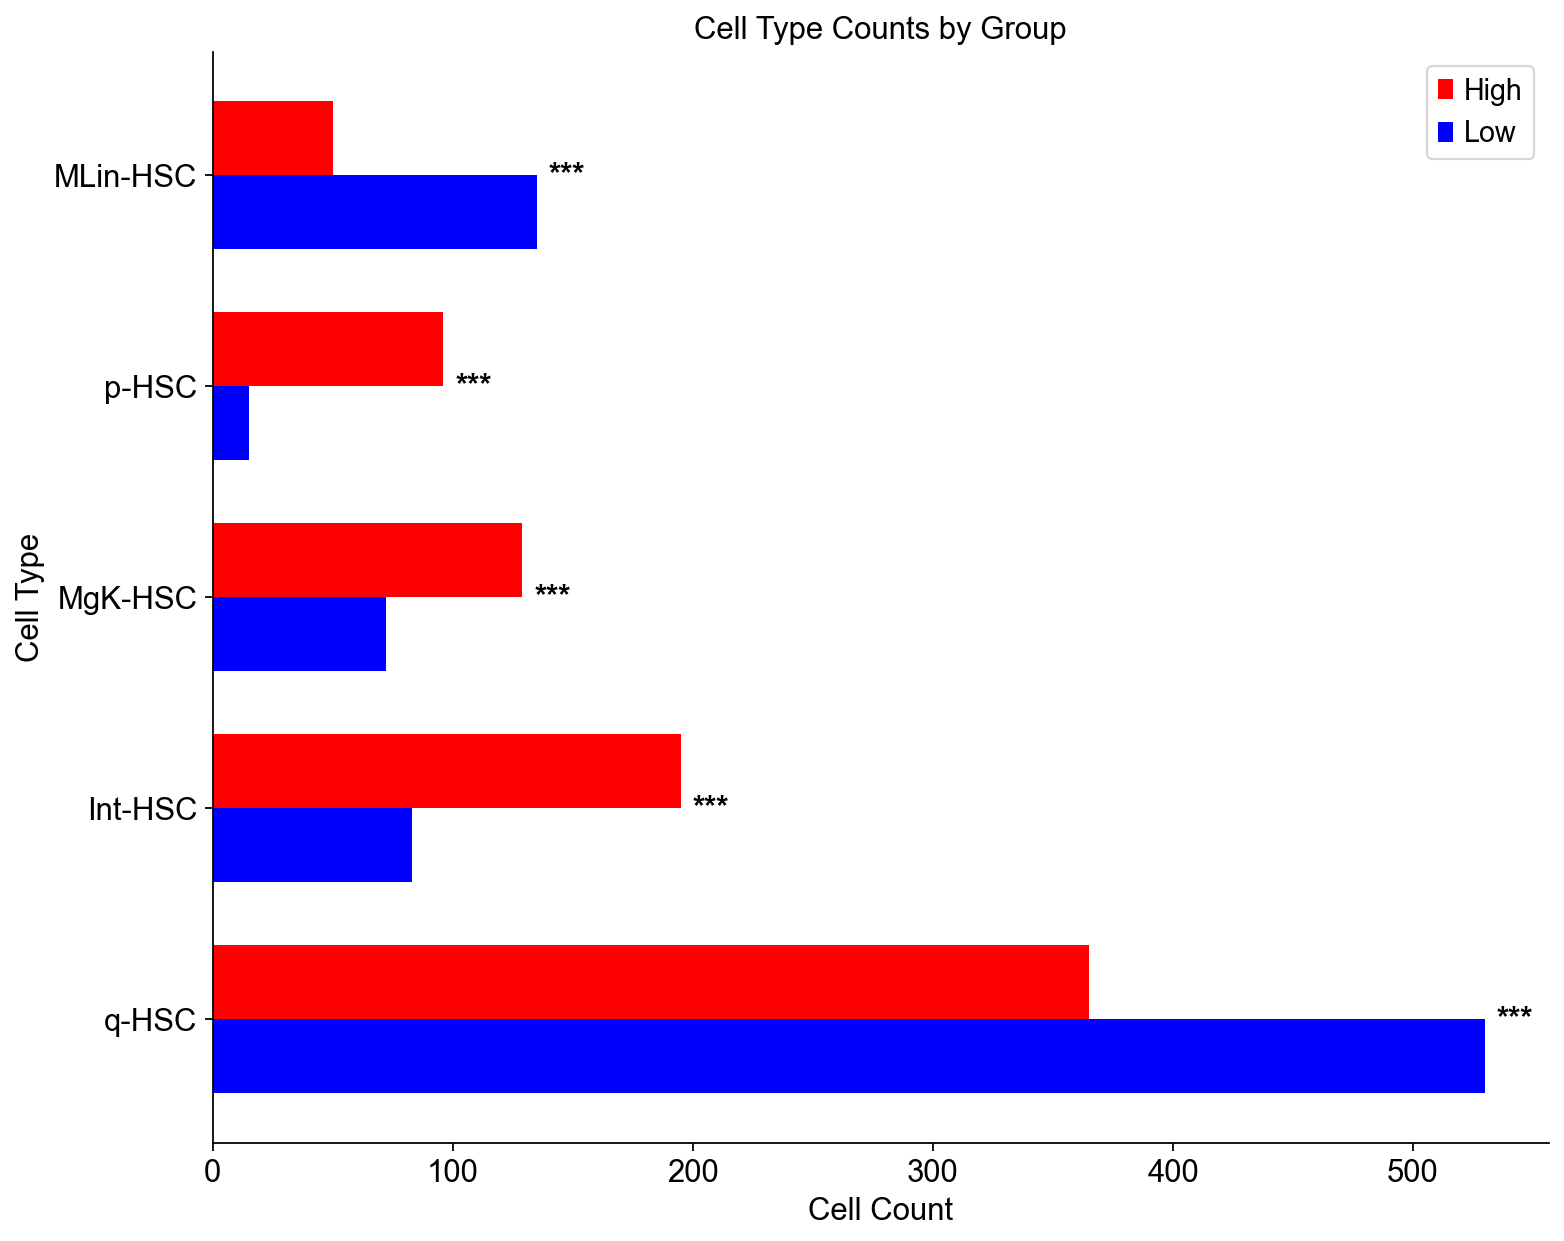

In [83]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rawcounts_horizontal(results_df):
    # Sort by total count to order bars
    results_df = results_df.sort_values(by=['high_count', 'low_count'], ascending=False).reset_index(drop=True)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    y = np.arange(len(results_df))
    bar_height = 0.35

    # Plot High (red) above Low (blue)
    plt.barh(y + bar_height/2, results_df['high_count'], height=bar_height, label='High', color='#FF0000')
    plt.barh(y - bar_height/2, results_df['low_count'], height=bar_height, label='Low', color='#0000FF')

    # Axis labels and formatting
    plt.xlabel('Cell Count')
    plt.ylabel('Cell Type')
    plt.yticks(y, results_df['cell_type'])
    plt.title('Cell Type Counts by Group')
    plt.legend()

    # Remove top/right spines and gridlines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Add horizontal significance stars next to the larger bar
    for i, row in results_df.iterrows():
        if row['significant']:
            high = row['high_count']
            low = row['low_count']
            max_count = max(high, low)
            # Star is aligned horizontally next to the longer bar
            plt.text(max_count + 5, i, row['stars'], va='center', ha='left', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run the updated function
plot_rawcounts_horizontal(results_df)
